# Hello this is a CNN
I am doing it

## Structure

We will have 4 separated convolutional networks, three for the 2D features and another to the 1D data, that will be flattened and concatenated into a MLP

In [1]:
from keras import models, layers
import tensorflow as tf
from tensorflow import keras

### Model

Features & Shapes:

- 2D Chromagram: (12, 321)
- 2D Mel Spectogram: (128, 321)
- 2D Fourier Tempogram: (508, 322)
- 1D Features: (40)

#### Chromagram Layer

In [2]:
chromagram_shape = (12, 321, 1)

chromagram_input = keras.Input(shape=chromagram_shape, name='chromagram_input')

chromalayer = layers.Conv2D(64, (3,3), activation='relu')(chromagram_input)
chromalayer = layers.MaxPooling2D((2,2))(chromalayer)
chromalayer = layers.Dropout(0.2)(chromalayer)
chromalayer = layers.Conv2D(128, (3,3), activation='relu')(chromalayer)
chromalayer = layers.MaxPooling2D((2,2))(chromalayer)
chromalayer = layers.Dropout(0.2)(chromalayer)
chromalayer = layers.Flatten()(chromalayer)

#### Mel Spectrogram Layer

In [3]:
mel_shape = (128, 321, 1)

mel_spectogram_input = keras.Input(shape=mel_shape, name='mel_spectogram_input')

mellayer = layers.Conv2D(32, (3,3), activation='relu')(mel_spectogram_input)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.2)(mellayer)
mellayer = layers.Conv2D(64, (3,3), activation='relu')(mellayer)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.2)(mellayer)
mellayer = layers.Flatten()(mellayer)

#### Fourier Tempogram Layer

In [4]:
tempogram_shape = (508,322, 1)

fourier_tempogram = keras.Input(shape=tempogram_shape, name='fourier_tempogram')

fourierlayer = layers.Conv2D(32, (3,3), activation='relu')(fourier_tempogram)
fourierlayer = layers.MaxPooling2D((2,2))(fourierlayer)
fourierlayer = layers.Dropout(0.2)(fourierlayer)
fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.MaxPooling2D((2,2))(fourierlayer)
fourierlayer = layers.Dropout(0.2)(fourierlayer)
fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.Flatten()(fourierlayer)

#### 1D Features Layer

In [5]:
features_1d_shape = (321, 4)

features_1d = keras.Input(shape=features_1d_shape, name='features_1d')

featureslayer = layers.Conv1D(32, 3, activation='relu')(features_1d)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Dropout(0.2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Dropout(0.2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.Flatten()(featureslayer)


#### Combined Layers

In [6]:
combined = layers.concatenate([chromalayer, fourierlayer, mellayer, featureslayer])
combined = layers.Dense(128, activation='relu')(combined)
combined = layers.Dropout(0.3)(combined)
combined = layers.Dense(64, activation='relu')(combined)
combined = layers.Dropout(0.3)(combined)
combined = layers.Dense(32, activation='softmax')(combined)
combined = layers.Dropout(0.3)(combined)
combined = layers.Dense(10, activation='softmax')(combined)

model = keras.Model(inputs=[chromagram_input, mel_spectogram_input, fourier_tempogram, features_1d], outputs=combined)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fourier_tempogram (InputLayer)  [(None, 508, 322, 1  0          []                               
                                )]                                                                
                                                                                                  
 features_1d (InputLayer)       [(None, 321, 4)]     0           []                               
                                                                                                  
 chromagram_input (InputLayer)  [(None, 12, 321, 1)  0           []                               
                                ]                                                                 
                                                                                              

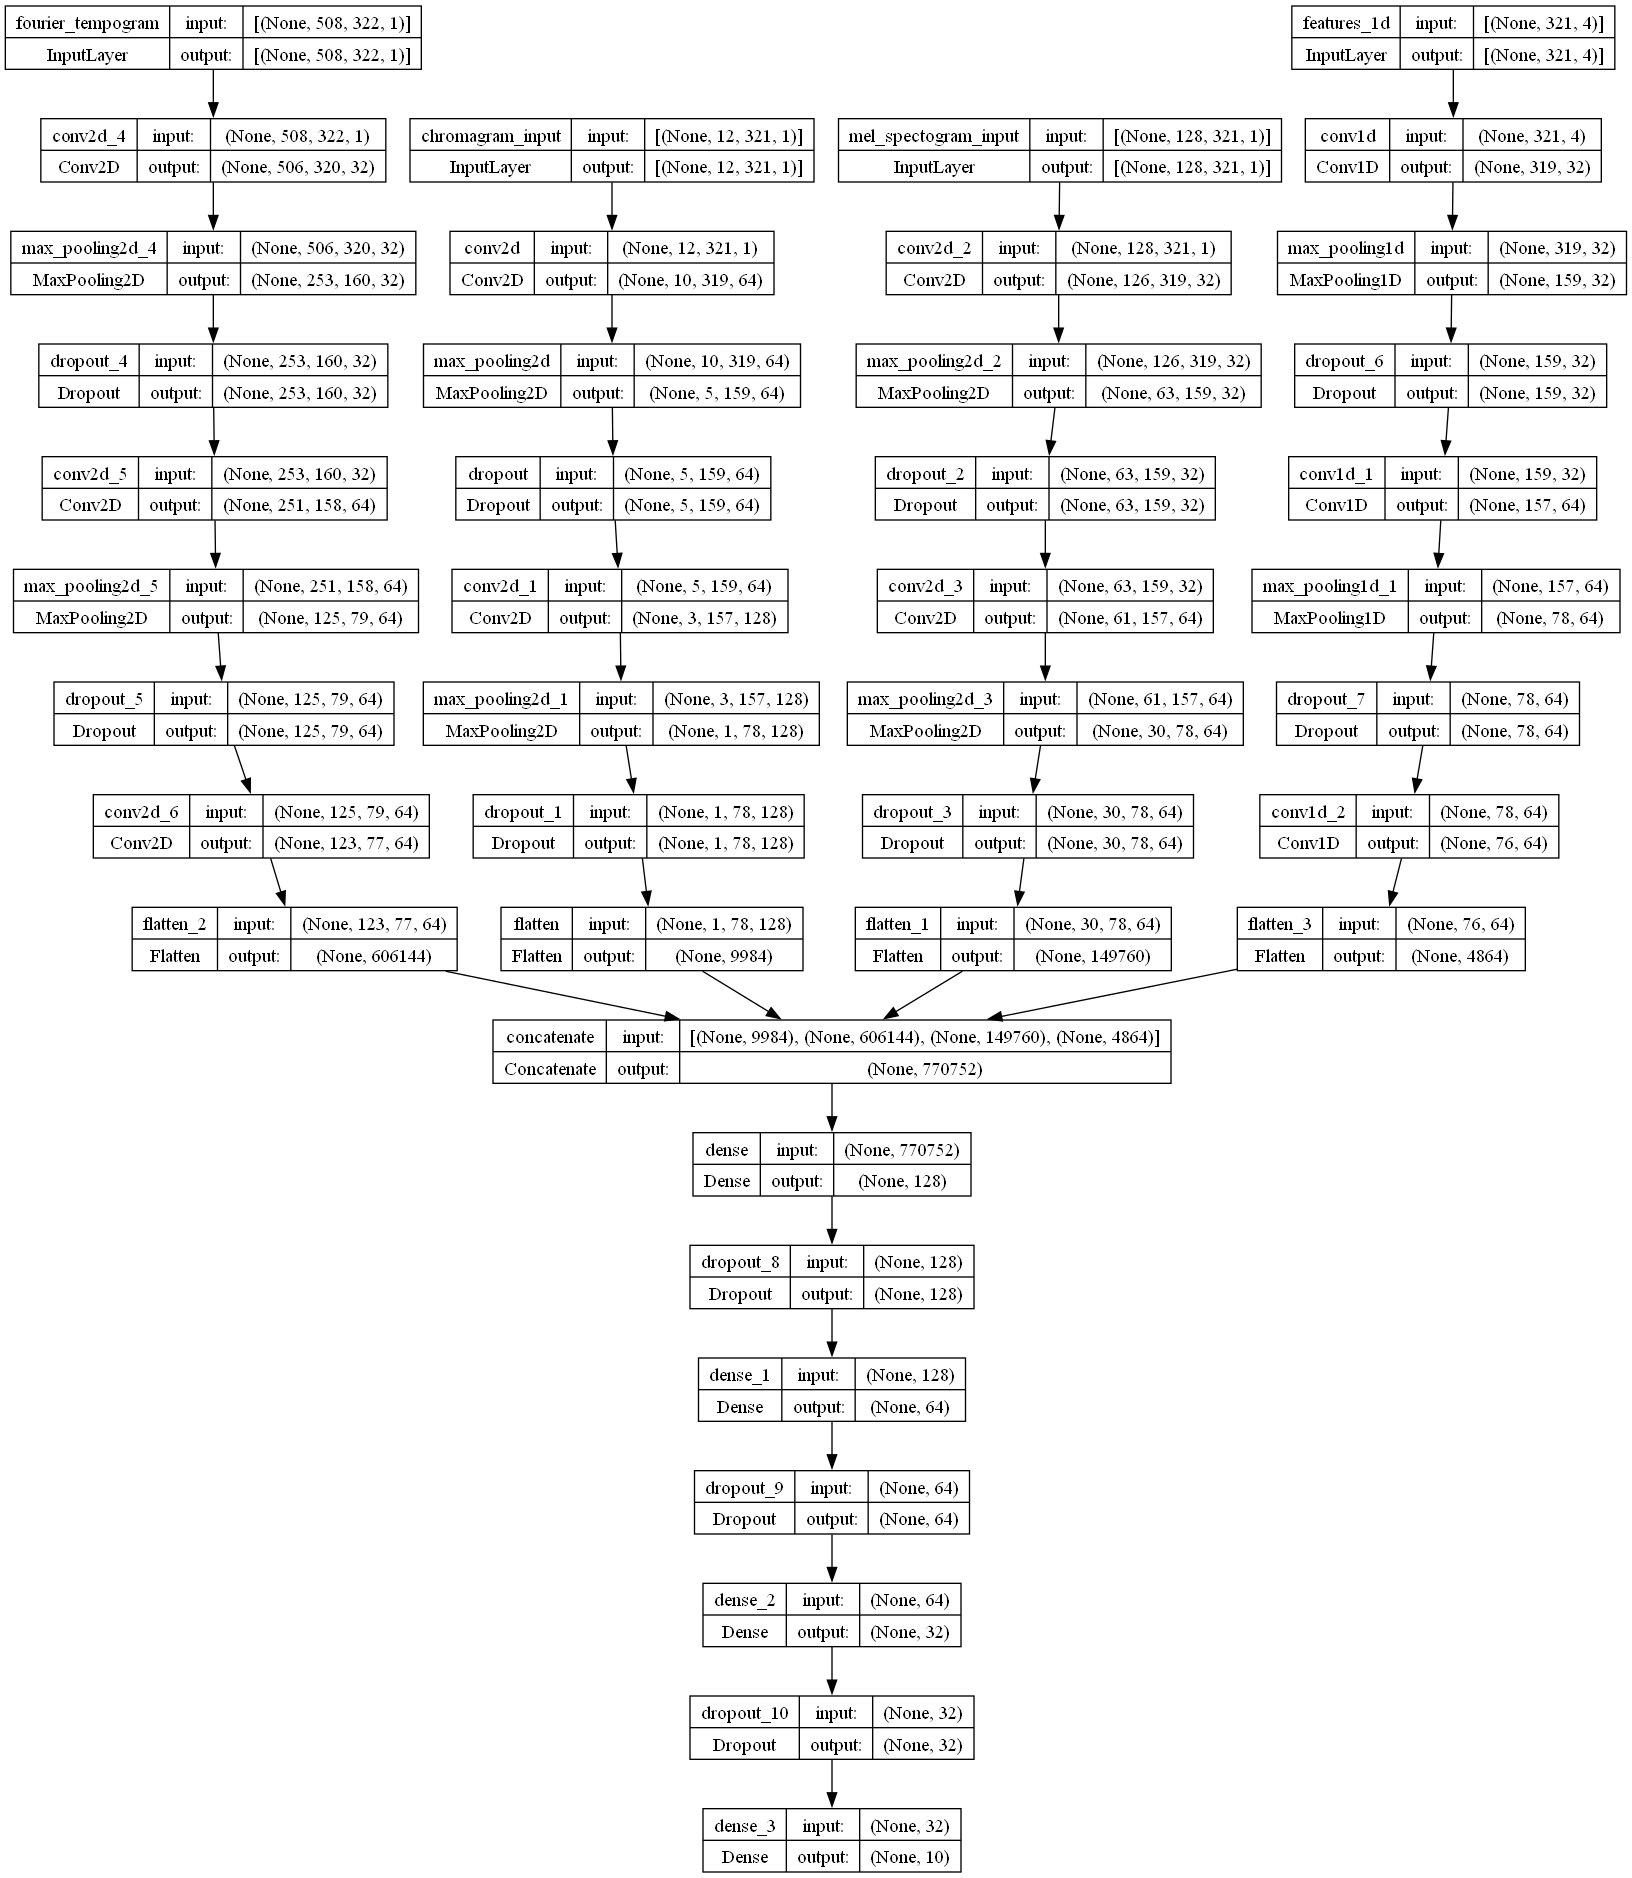

In [7]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

### Importing the Data

In [8]:
import pickle
import pandas as pd

with open('assets/fold5_df.pkl', 'rb') as f:
    conv_data = pickle.load(f)
f.close()

conv_data = pd.DataFrame(conv_data)

### Creating the target class

In [9]:
from sklearn.model_selection import train_test_split
X = conv_data.drop(columns=['slice_file_name','classID'])
y = conv_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=conv_data['classID'])

#### Separating the test train into the respective layer inputs

In [14]:
X_train_chroma = X_train["chromagram"]
X_train_mel = X_train["mel_spectogram"]
X_train_fourier = X_train["fourier_tempogram"]
X_train_1d = X_train.drop(columns=['chromagram','mel_spectogram','fourier_tempogram'])

In [15]:
import numpy as np
X_train_1d1 = X_train_1d["spectral_centroid"]
X_train_1d1 = np.array(X_train_1d1)
X_train_1d1 = tf.convert_to_tensor(X_train_1d1)
X_train_1d2 = X_train_1d["spectral_bandwidth"]
X_train_1d2 = np.array(X_train_1d2)
X_train_1d2 = tf.convert_to_tensor(X_train_1d2)
X_train_1d3 = X_train_1d["spectral_flatness"]
X_train_1d3 = np.array(X_train_1d3)
X_train_1d3 = tf.convert_to_tensor(X_train_1d3)


X_train_1d = tf.stack([X_train_1d1, X_train_1d2, X_train_1d3], axis=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model.fit(
    {'features_1d': X_train_1d, 'chromagram_input': X_train_chroma, 'mel_spectogram_input': X_train_mel, 'fourier_tempogram': X_train_fourier},
    epochs=10,
    batch_size=32
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).